In [1]:
import pandas as pd
import numpy as np

# Utils

In [2]:
def return_ambiguos(df):
    unique_acronyms = df.groupby('Acronym')['Resolution'].nunique()
    ambiguous_acronyms = unique_acronyms[unique_acronyms > 1].index
    ambigous_df = df[df['Acronym'].isin(ambiguous_acronyms)]
    ambigous_df = ambigous_df.sort_values(by='Resolution')
    return ambigous_df

# EDA

In [3]:
df_sintatic = pd.read_pickle("data/sintatic_wemb_MiniLM_L6_v2.pkl")

In [4]:
df_sintatic

,Sentence,Resolution,Acronym,Sentence_Emb,Resolution_Emb
600,Managing AR is crucial for maintaining a healt...,Accounts Receivable,AR,"[[-0.043010436, 0.030251851, -0.4291916, -0.00...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
603,Effective AR management reduces the risk of ba...,Accounts Receivable,AR,"[[-0.07896995, 0.22533315, -0.024554426, -0.20...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
604,Timely follow-ups with customers can speed up ...,Accounts Receivable,AR,"[[-0.14787723, -0.34664398, -0.7436014, -0.067...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
605,AR software automates invoice generation and p...,Accounts Receivable,AR,"[[-0.3722177, -0.23643449, -0.63709235, -0.106...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
606,Accurate AR records are essential for financia...,Accounts Receivable,AR,"[[-0.34439862, -0.46760595, -0.5512057, 0.2068...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
...,...,...,...,...,...
8396,SMEs are masters of their domain.,Subject Matter Expert,SME,"[[-0.2923872, -0.4277274, -0.11941463, 0.09195...","[[0.05482929, -0.032087043, -0.21160349, -0.11..."
8300,SMEs inspire professional development.,Subject Matter Expert,SME,"[[0.13086526, -0.17560026, -0.11393371, -0.061...","[[0.05482929, -0.032087043, -0.21160349, -0.11..."
8376,SMEs specialize in their niches.,Subject Matter Expert,SME,"[[0.20829095, -0.30388296, -0.105574675, -0.07...","[[0.05482929, -0.032087043, -0.21160349, -0.11..."
8388,SMEs excel in their respective fields.,Subject Matter Expert,SME,"[[0.025190588, -0.20149279, -0.15659817, -0.01...","[[0.05482929, -0.032087043, -0.21160349, -0.11..."


In [5]:
df_sintatic["Acronym"].unique()

array(['AR', 'AI', 'ATS', 'CTA', 'CA', 'CP', 'CPM', 'CRM', 'DEI', 'ER',
       'EVP', 'MBO', 'MA', 'PM', 'PR', 'RPO', 'RA', 'ROI', 'SME'],
      dtype=object)

In [6]:
df_sintatic.columns

Index(['Sentence', 'Resolution', 'Acronym', 'Sentence_Emb', 'Resolution_Emb'], dtype='object')

# Disambiguation 

In [7]:
from disambiguation import embedding_based_only

results = {
    "Label": [],
    "Prediction": [],
    "True": [],
}

results = embedding_based_only(df_sintatic, results)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Label')

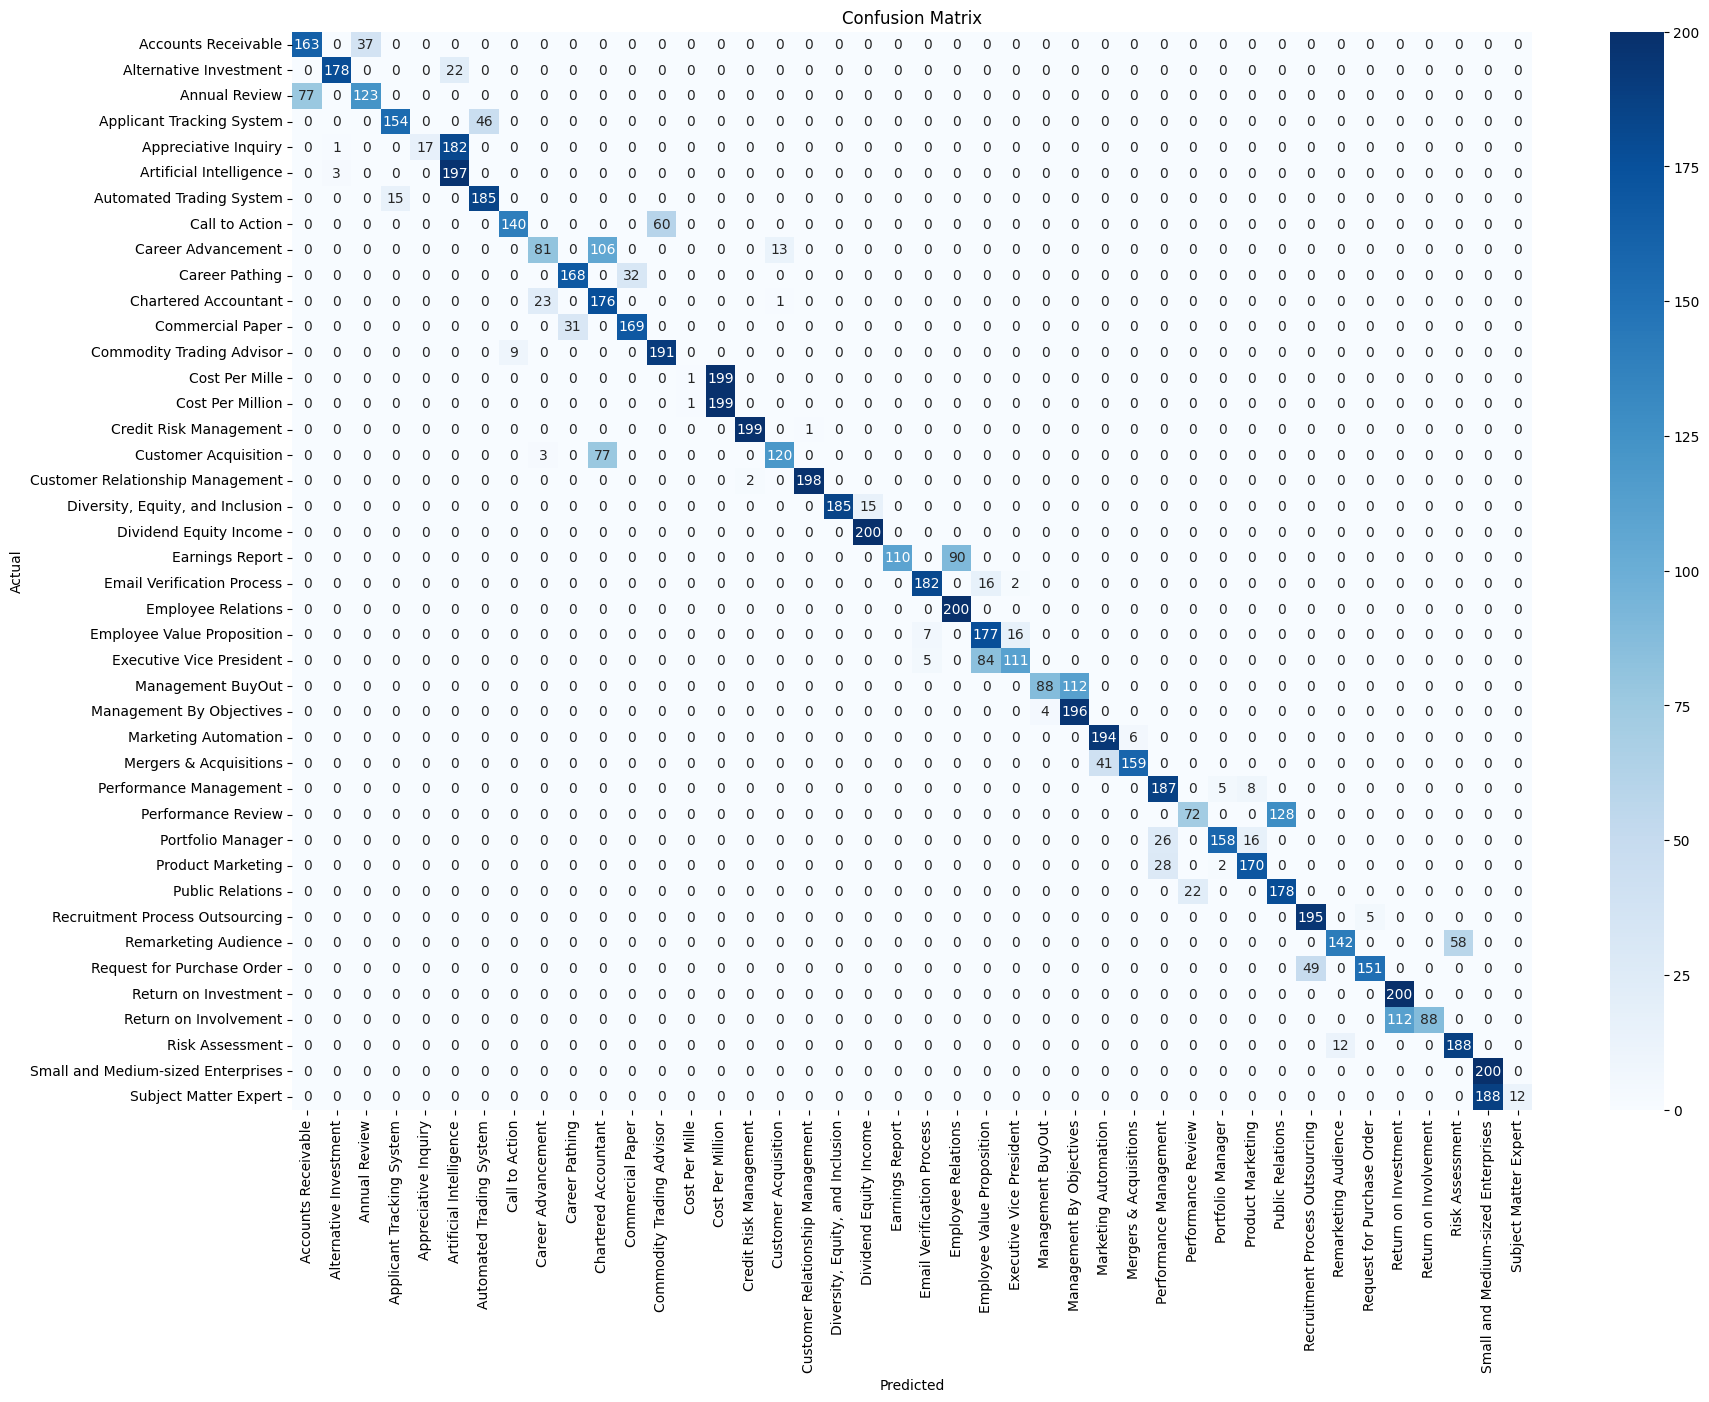

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score
import seaborn as sns

confusion = confusion_matrix(results_df['Label'], results_df['Prediction'])

plt.figure(figsize=(20, 14))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=results_df["Label"].unique(), yticklabels=results_df["Label"].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

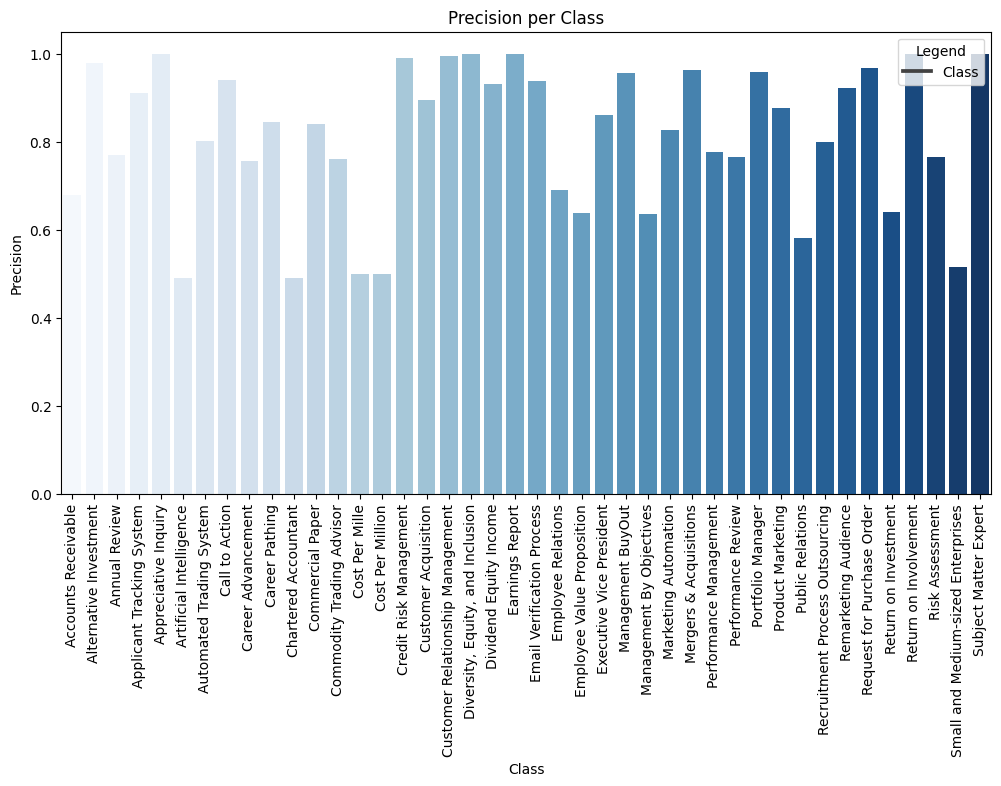

In [9]:
class_labels = results_df['Label'].unique()
precisions = []

for label in class_labels:
    true_labels = results_df['Label'] == label
    predicted_labels = results_df['Prediction'] == label
    precision = precision_score(true_labels, predicted_labels)
    precisions.append(precision)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=class_labels, y=precisions, palette='Blues')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision per Class')
plt.xticks(rotation=90)

ax.set_xticks(range(len(class_labels)))
ax.set_xticklabels(class_labels)
ax.legend(title='Legend', labels=['Class'])

plt.show()

In [10]:
def calculate_precisions(results_df):
    unique_labels = results_df["Label"].unique()
    precisions = []
    for label in unique_labels:
        true_labels = results_df['Label'] == label
        predicted_labels = results_df['Prediction'] == label
        precision = precision_score(true_labels, predicted_labels)
        precisions.append(precision)
    return unique_labels, precisions

def filter_low_precision_classes(results_df, precisions, threshold=0.70):
    low_precision_classes = [label for label, precision in zip(unique_labels, precisions) if precision >= threshold]
    return results_df[~results_df['Label'].isin(low_precision_classes)]

unique_labels, precisions = calculate_precisions(results_df)
filtered_results_df = filter_low_precision_classes(results_df, precisions, threshold=0.70)

for i, acc_l in enumerate(filtered_results_df["Label"].unique()):
    precision = precisions[list(unique_labels).index(acc_l)]
    print(f"{i+1}. {acc_l}, {precision:.2f}")

1. Accounts Receivable, 0.68
2. Artificial Intelligence, 0.49
3. Chartered Accountant, 0.49
4. Cost Per Mille, 0.50
5. Cost Per Million, 0.50
6. Employee Relations, 0.69
7. Employee Value Proposition, 0.64
8. Management By Objectives, 0.64
9. Public Relations, 0.58
10. Return on Investment, 0.64
11. Small and Medium-sized Enterprises, 0.52
